In [1]:
!pip install keras
!pip install sklearn
!pip install matplotlib
!pip install -U -q PyDrive

In [2]:
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


In [0]:
from keras import backend as K
cfg = K.tf.ConfigProto()
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
file_import = drive.CreateFile({'id':'1p1bsltfTcIrZ_kfE6kwGTPzcdXorHbb2'})
file_import.GetContentFile('colab_setup.py') 
from colab_setup import setup

setup(drive)

In [6]:
!ls

colab_setup.py			 roc_auc_callback.py	X_train.npy
custom_fast_text_embeddings.npy  sample_submission.csv	X_val.npy
datalab				 train_model.py		y_test.npy
fast_text_embeddings.npy	 X_submission.npy	y_train_full.npy
plot_history.py			 X_test.npy		y_train.npy
__pycache__			 X_train_full.npy	y_val.npy


In [0]:
import numpy as np
import os

from plot_history import plot_history
from roc_auc_callback import RocAucCallback
from train_model import train_with_cv, train_with_submitting, evaluate_on_test

from keras.layers import *
from keras.layers.merge import *
from keras.initializers import *
from keras.models import Model

In [0]:
featureMapsNumber = 64
featureMapKernelSize = 3

maxPoolingStride = 2
maxPoolingKernelSize = 3

def convolution_block(input_layer, should_preactivate = False, dropout_rate = 0.2, dropout_mode = 'spatial'):
    convolution_block_input = Input(shape=(int(input_layer.shape[1]), int(input_layer.shape[2])))
    model = convolution_block_input
    
    if(should_preactivate):
        model = BatchNormalization()(model)
        model = ELU()(model)
        model = Conv1D(
            featureMapsNumber, 
            kernel_size=featureMapKernelSize, 
            padding='same', 
            activation='linear', 
            kernel_initializer = 'he_normal'
        )(model)
    else:
        model = Conv1D(
            featureMapsNumber, 
            kernel_size=featureMapKernelSize, 
            padding='same', 
            activation='linear', 
            kernel_initializer = 'he_normal'
        )(model)        
        model = BatchNormalization()(model)
        model = ELU()(model)
        
    convolution_block_output = model
    
    if(dropout_mode == 'vanilla'):
        convolution_block_output = Dropout(dropout_rate)(model)
    if(dropout_mode == 'spatial'):
        convolution_block_output = SpatialDropout1D(dropout_rate)(model)
        
    return Model(
        inputs=[convolution_block_input], 
        outputs=[convolution_block_output]
    )(input_layer)



In [0]:
def dpcnn_block(input_layer, dropout_rate = 0.2, dropout_mode = 'spatial'):
    dpcnn_block_input = Input(shape=(int(input_layer.shape[1]), int(input_layer.shape[2])))
    dpcnn_block_pool = MaxPooling1D(pool_size=3, strides=2, padding='valid')(dpcnn_block_input)
    
    dpcnn_conv_1 = convolution_block(
        dpcnn_block_pool, 
        should_preactivate = True, 
        dropout_mode = dropout_mode,
        dropout_rate = dropout_rate
    )
    dpcnn_conv_2 = convolution_block(
        dpcnn_conv_1, 
        should_preactivate = True, 
        dropout_mode = dropout_mode,
        dropout_rate = dropout_rate
    )
    
    dpcnn_block_output = add([dpcnn_conv_2, dpcnn_block_pool])
    
    return Model(
        inputs=[dpcnn_block_input], 
        outputs=[dpcnn_block_output]
    )(input_layer)

In [0]:
def yoon_kim_feature_extractor(filtersNumber, inputLayer):
    extractor_block_input = Input(shape=(int(inputLayer.shape[1]), int(inputLayer.shape[2])))

    block_1_conv_1 = Conv1D(filtersNumber, 1, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(extractor_block_input)
    block_1_batchnorm1 = BatchNormalization()(block_1_conv_1)
    block_1_batchnorm1 = ELU()(block_1_batchnorm1)
    block_1_max_pool1 = GlobalMaxPooling1D()(block_1_batchnorm1)

    block_1_conv_2 = Conv1D(filtersNumber, 2, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(extractor_block_input)
    block_1_batchnorm2 = BatchNormalization()(block_1_conv_2)
    block_1_batchnorm2 = ELU()(block_1_batchnorm2)
    block_1_max_pool2 = GlobalMaxPooling1D()(block_1_batchnorm2)

    block_1_conv_3 = Conv1D(filtersNumber, 3, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(extractor_block_input)
    block_1_batchnorm3 = BatchNormalization()(block_1_conv_3)
    block_1_batchnorm3 = ELU()(block_1_batchnorm3)
    block_1_max_pool3 = GlobalMaxPooling1D()(block_1_batchnorm3)

    block_1_conv_4 = Conv1D(filtersNumber, 5, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(extractor_block_input)
    block_1_batchnorm4 = BatchNormalization()(block_1_conv_4)
    block_1_batchnorm4 = ELU()(block_1_batchnorm4)
    block_1_max_pool4 = GlobalMaxPooling1D()(block_1_batchnorm4)

    block_1_features = concatenate([
        block_1_max_pool1, 
        block_1_max_pool2, 
        block_1_max_pool3, 
        block_1_max_pool4
    ])
    
    extractor_block_output = Dropout(0.2)(block_1_features)
    
    return Model(
        inputs = [extractor_block_input], 
        outputs=[extractor_block_output]
    )(inputLayer)

In [0]:
def classification_block(input_layer, dropout_rate = 0.2):
      
    model = Dense(256, activation = 'linear', kernel_initializer = 'he_normal')(input_layer)
    model = BatchNormalization()(model)
    model = ELU()(model)
    model = Dropout(dropout_rate)(model)
    
    model = Dense(256, activation = 'linear', kernel_initializer = 'he_normal')(model)
    model = BatchNormalization()(model)
    model = ELU()(model)
    model = Dropout(dropout_rate)(model)

    classification_block_output = Dense(6, activation='sigmoid', kernel_initializer = 'glorot_normal')(model)
    
    return classification_block_output

In [12]:
max_words= 30000
max_words_length = 400
embedding_dimension = 300

input_layer = Input(shape=(max_words_length,))

pretrained_embedding_layer = Embedding(
    max_words, 
    output_dim=embedding_dimension, 
    input_length=max_words_length,
    weights = [np.load('fast_text_embeddings.npy')],
    trainable = False
)(input_layer)
pretrained_embedding_layer = SpatialDropout1D(0.2)(pretrained_embedding_layer)

custom_embedding_layer = Embedding(
    max_words, 
    output_dim=embedding_dimension, 
    input_length=max_words_length,
    weights = [np.load('custom_fast_text_embeddings.npy')],
    trainable = False
)(input_layer)
custom_embedding_layer = SpatialDropout1D(0.2)(custom_embedding_layer)

averaged_embedding_layer = Average()([pretrained_embedding_layer, custom_embedding_layer])
averaged_embedding_layer = SpatialDropout1D(0.2)(averaged_embedding_layer)

preprocess_1 = convolution_block(averaged_embedding_layer, dropout_mode = 'spatial')
preprocess_2 = convolution_block(preprocess_1, dropout_mode = 'spatial')

model = add([preprocess_1, preprocess_2])

model = dpcnn_block(model)
model = dpcnn_block(model)
model = dpcnn_block(model)
model = dpcnn_block(model)
model = dpcnn_block(model)
model = dpcnn_block(model)
model = dpcnn_block(model)

model = concatenate([
    Flatten()(model), 
    yoon_kim_feature_extractor(featureMapsNumber, model)
])
output_layer = classification_block(model)

model = Model(inputs=[input_layer], outputs=[output_layer])
            
model.summary()

model.compile(
    loss='binary_crossentropy', 
    optimizer='Adam',
    metrics=['accuracy']
)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 400)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 400, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
spatial_dr

Small Batch Training

In [13]:
history = train_with_cv(model, batchSize=32, rocEvery = 2)

Train on 102124 samples, validate on 25532 samples
Epoch 1/32
 21408/102124 [=====>........................] - ETA: 5:48 - loss: 0.1245 - acc: 0.9598

102112/102124 [============================>.] - ETA: 0s - loss: 0.0774 - acc: 0.9736

102124/102124 [==============================] - 404s 4ms/step - loss: 0.0774 - acc: 0.9736 - val_loss: 0.0492 - val_acc: 0.9815
Epoch 2/32
 14016/102124 [===>..........................] - ETA: 5:04 - loss: 0.0579 - acc: 0.9797

102112/102124 [============================>.] - ETA: 0s - loss: 0.0573 - acc: 0.9793

102124/102124 [==============================] - 379s 4ms/step - loss: 0.0573 - acc: 0.9793 - val_loss: 0.0480 - val_acc: 0.9817
roc-auc: 0.9754 - roc-auc_val: 0.9719                                                                                                    
Epoch 3/32
  8736/102124 [=>............................] - ETA: 6:00 - loss: 0.0554 - acc: 0.9798

102112/102124 [============================>.] - ETA: 0s - loss: 0.0540 - acc: 0.9803

102124/102124 [==============================] - 395s 4ms/step - loss: 0.0540 - acc: 0.9803 - val_loss: 0.0543 - val_acc: 0.9811
Epoch 4/32
 14048/102124 [===>..........................] - ETA: 5:41 - loss: 0.0518 - acc: 0.9808

102112/102124 [============================>.] - ETA: 0s - loss: 0.0525 - acc: 0.9806

102124/102124 [==============================] - 391s 4ms/step - loss: 0.0525 - acc: 0.9806 - val_loss: 0.0454 - val_acc: 0.9829
roc-auc: 0.9794 - roc-auc_val: 0.9761                                                                                                    
Epoch 5/32
  8736/102124 [=>............................] - ETA: 5:15 - loss: 0.0514 - acc: 0.9806

102112/102124 [============================>.] - ETA: 0s - loss: 0.0506 - acc: 0.9813

102124/102124 [==============================] - 388s 4ms/step - loss: 0.0507 - acc: 0.9813 - val_loss: 0.0451 - val_acc: 0.9830
Epoch 6/32
 14048/102124 [===>..........................] - ETA: 5:40 - loss: 0.0510 - acc: 0.9816

102112/102124 [============================>.] - ETA: 0s - loss: 0.0492 - acc: 0.9817

102124/102124 [==============================] - 393s 4ms/step - loss: 0.0492 - acc: 0.9817 - val_loss: 0.0453 - val_acc: 0.9827
roc-auc: 0.9816 - roc-auc_val: 0.9777                                                                                                    
Epoch 7/32
  8736/102124 [=>............................] - ETA: 5:26 - loss: 0.0466 - acc: 0.9829

102112/102124 [============================>.] - ETA: 0s - loss: 0.0483 - acc: 0.9819

102124/102124 [==============================] - 381s 4ms/step - loss: 0.0483 - acc: 0.9819 - val_loss: 0.0438 - val_acc: 0.9832
Epoch 8/32
 14016/102124 [===>..........................] - ETA: 5:04 - loss: 0.0476 - acc: 0.9819

102112/102124 [============================>.] - ETA: 0s - loss: 0.0473 - acc: 0.9822

102124/102124 [==============================] - 367s 4ms/step - loss: 0.0473 - acc: 0.9822 - val_loss: 0.0442 - val_acc: 0.9833
roc-auc: 0.9845 - roc-auc_val: 0.9783                                                                                                    
Epoch 9/32
  8736/102124 [=>............................] - ETA: 5:28 - loss: 0.0447 - acc: 0.9836

102112/102124 [============================>.] - ETA: 0s - loss: 0.0461 - acc: 0.9826

102124/102124 [==============================] - 368s 4ms/step - loss: 0.0461 - acc: 0.9826 - val_loss: 0.0442 - val_acc: 0.9830

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.00021763764380011708.
Epoch 10/32
  8000/102124 [=>............................] - ETA: 5:27 - loss: 0.0442 - acc: 0.9832

102112/102124 [============================>.] - ETA: 0s - loss: 0.0454 - acc: 0.9827

102124/102124 [==============================] - 369s 4ms/step - loss: 0.0454 - acc: 0.9827 - val_loss: 0.0432 - val_acc: 0.9838
roc-auc: 0.9866 - roc-auc_val: 0.98                                                                                                    
Epoch 11/32
  8704/102124 [=>............................] - ETA: 5:19 - loss: 0.0423 - acc: 0.9840

102112/102124 [============================>.] - ETA: 0s - loss: 0.0447 - acc: 0.9827

102124/102124 [==============================] - 368s 4ms/step - loss: 0.0447 - acc: 0.9827 - val_loss: 0.0426 - val_acc: 0.9835
Epoch 12/32
 13984/102124 [===>..........................] - ETA: 5:06 - loss: 0.0431 - acc: 0.9836

102112/102124 [============================>.] - ETA: 0s - loss: 0.0440 - acc: 0.9831

102124/102124 [==============================] - 368s 4ms/step - loss: 0.0440 - acc: 0.9831 - val_loss: 0.0430 - val_acc: 0.9834
roc-auc: 0.9882 - roc-auc_val: 0.9805                                                                                                    
Epoch 13/32
  8704/102124 [=>............................] - ETA: 5:19 - loss: 0.0440 - acc: 0.9830

102112/102124 [============================>.] - ETA: 0s - loss: 0.0438 - acc: 0.9831

102124/102124 [==============================] - 366s 4ms/step - loss: 0.0438 - acc: 0.9831 - val_loss: 0.0423 - val_acc: 0.9837
Epoch 14/32
 13984/102124 [===>..........................] - ETA: 5:05 - loss: 0.0427 - acc: 0.9837

102112/102124 [============================>.] - ETA: 0s - loss: 0.0431 - acc: 0.9833

102124/102124 [==============================] - 367s 4ms/step - loss: 0.0431 - acc: 0.9833 - val_loss: 0.0425 - val_acc: 0.9838
roc-auc: 0.989 - roc-auc_val: 0.9813                                                                                                    
Epoch 15/32
  8736/102124 [=>............................] - ETA: 5:27 - loss: 0.0414 - acc: 0.9837

102112/102124 [============================>.] - ETA: 0s - loss: 0.0421 - acc: 0.9835

102124/102124 [==============================] - 368s 4ms/step - loss: 0.0421 - acc: 0.9835 - val_loss: 0.0422 - val_acc: 0.9837
Epoch 16/32
 13984/102124 [===>..........................] - ETA: 5:04 - loss: 0.0414 - acc: 0.9838

102112/102124 [============================>.] - ETA: 0s - loss: 0.0417 - acc: 0.9838

102124/102124 [==============================] - 367s 4ms/step - loss: 0.0418 - acc: 0.9837 - val_loss: 0.0419 - val_acc: 0.9841
roc-auc: 0.9898 - roc-auc_val: 0.9818                                                                                                    
Epoch 17/32
  8672/102124 [=>............................] - ETA: 5:26 - loss: 0.0406 - acc: 0.9844

102112/102124 [============================>.] - ETA: 0s - loss: 0.0413 - acc: 0.9838

102124/102124 [==============================] - 368s 4ms/step - loss: 0.0413 - acc: 0.9838 - val_loss: 0.0428 - val_acc: 0.9835
Epoch 18/32
 13984/102124 [===>..........................] - ETA: 5:05 - loss: 0.0418 - acc: 0.9833

102112/102124 [============================>.] - ETA: 0s - loss: 0.0411 - acc: 0.9840

102124/102124 [==============================] - 367s 4ms/step - loss: 0.0411 - acc: 0.9840 - val_loss: 0.0421 - val_acc: 0.9837
roc-auc: 0.9899 - roc-auc_val: 0.9815                                                                                                    
Epoch 19/32
  8704/102124 [=>............................] - ETA: 5:17 - loss: 0.0423 - acc: 0.9839

102112/102124 [============================>.] - ETA: 0s - loss: 0.0409 - acc: 0.9840

102124/102124 [==============================] - 369s 4ms/step - loss: 0.0409 - acc: 0.9840 - val_loss: 0.0417 - val_acc: 0.9839
Epoch 20/32
 13984/102124 [===>..........................] - ETA: 5:08 - loss: 0.0419 - acc: 0.9835

102112/102124 [============================>.] - ETA: 0s - loss: 0.0404 - acc: 0.9843

102124/102124 [==============================] - 368s 4ms/step - loss: 0.0404 - acc: 0.9843 - val_loss: 0.0412 - val_acc: 0.9842
roc-auc: 0.9906 - roc-auc_val: 0.9821                                                                                                    
Epoch 21/32
  8704/102124 [=>............................] - ETA: 5:24 - loss: 0.0407 - acc: 0.9841

102112/102124 [============================>.] - ETA: 0s - loss: 0.0403 - acc: 0.9842

102124/102124 [==============================] - 369s 4ms/step - loss: 0.0403 - acc: 0.9842 - val_loss: 0.0418 - val_acc: 0.9840
Epoch 22/32
 13984/102124 [===>..........................] - ETA: 5:04 - loss: 0.0382 - acc: 0.9849

102112/102124 [============================>.] - ETA: 0s - loss: 0.0401 - acc: 0.9842

102124/102124 [==============================] - 365s 4ms/step - loss: 0.0401 - acc: 0.9842 - val_loss: 0.0416 - val_acc: 0.9840

Epoch 00022: ReduceLROnPlateau reducing learning rate to 5.632815373246558e-05.
roc-auc: 0.9907 - roc-auc_val: 0.9818                                                                                                    
Epoch 23/32
  5952/102124 [>.............................] - ETA: 5:28 - loss: 0.0400 - acc: 0.9851

102112/102124 [============================>.] - ETA: 0s - loss: 0.0399 - acc: 0.9844

102124/102124 [==============================] - 372s 4ms/step - loss: 0.0399 - acc: 0.9844 - val_loss: 0.0424 - val_acc: 0.9835
Epoch 24/32
 13984/102124 [===>..........................] - ETA: 6:01 - loss: 0.0387 - acc: 0.9846

102112/102124 [============================>.] - ETA: 0s - loss: 0.0395 - acc: 0.9845

102124/102124 [==============================] - 390s 4ms/step - loss: 0.0395 - acc: 0.9845 - val_loss: 0.0415 - val_acc: 0.9841
roc-auc: 0.9911 - roc-auc_val: 0.9819                                                                                                    
Epoch 25/32
  8704/102124 [=>............................] - ETA: 5:37 - loss: 0.0426 - acc: 0.9836

102112/102124 [============================>.] - ETA: 0s - loss: 0.0394 - acc: 0.9845

102124/102124 [==============================] - 391s 4ms/step - loss: 0.0394 - acc: 0.9845 - val_loss: 0.0416 - val_acc: 0.9838
Epoch 26/32
 13888/102124 [===>..........................] - ETA: 5:11 - loss: 0.0395 - acc: 0.9842

102112/102124 [============================>.] - ETA: 0s - loss: 0.0394 - acc: 0.9847

102124/102124 [==============================] - 391s 4ms/step - loss: 0.0394 - acc: 0.9847 - val_loss: 0.0414 - val_acc: 0.9840
roc-auc: 0.9914 - roc-auc_val: 0.9824                                                                                                    
Epoch 27/32
  8672/102124 [=>............................] - ETA: 5:23 - loss: 0.0391 - acc: 0.9847

102112/102124 [============================>.] - ETA: 0s - loss: 0.0392 - acc: 0.9844

102124/102124 [==============================] - 387s 4ms/step - loss: 0.0392 - acc: 0.9844 - val_loss: 0.0427 - val_acc: 0.9836
Epoch 28/32
 13984/102124 [===>..........................] - ETA: 5:21 - loss: 0.0391 - acc: 0.9845

102112/102124 [============================>.] - ETA: 0s - loss: 0.0389 - acc: 0.9846

102124/102124 [==============================] - 384s 4ms/step - loss: 0.0389 - acc: 0.9846 - val_loss: 0.0418 - val_acc: 0.9839
roc-auc: 0.9915 - roc-auc_val: 0.9826                                                                                                    
Epoch 29/32
  8704/102124 [=>............................] - ETA: 6:33 - loss: 0.0371 - acc: 0.9854

102112/102124 [============================>.] - ETA: 0s - loss: 0.0389 - acc: 0.9847

102124/102124 [==============================] - 395s 4ms/step - loss: 0.0389 - acc: 0.9847 - val_loss: 0.0415 - val_acc: 0.9841
Epoch 30/32
 13984/102124 [===>..........................] - ETA: 5:48 - loss: 0.0387 - acc: 0.9845

102112/102124 [============================>.] - ETA: 0s - loss: 0.0389 - acc: 0.9847

102124/102124 [==============================] - 390s 4ms/step - loss: 0.0389 - acc: 0.9847 - val_loss: 0.0417 - val_acc: 0.9840
roc-auc: 0.9916 - roc-auc_val: 0.9827                                                                                                    


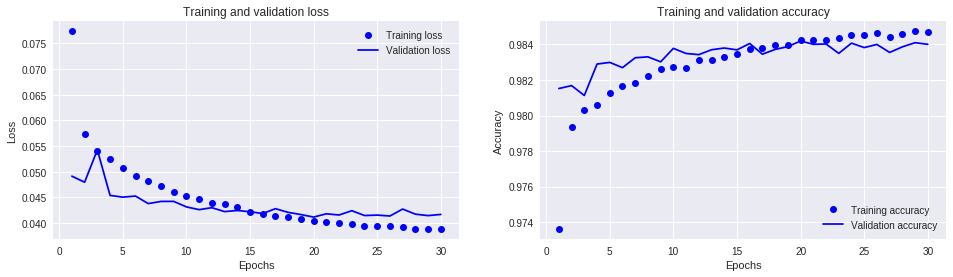

In [14]:
plot_history(history)

In [15]:
print(evaluate_on_test(model))

31915/31915 [==============================] - 19s 606us/step
([0.040469734096754015, 0.984390815628858], 0.985592489159583)
